#  Supervised Learning Assignment

####  S. Parker 2016

This notebook will examine the phishing dataset with Adaboost.  It will look at the effectiveness of the decision trees relative to:

*  Levels in the decision tree
*  Number of training samples
*  Bias vs variance calculations
*  Performance metrics (memory used, time to fit, time to predict)

In [1]:
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.externals.six import StringIO  
import pandas as pd
import pydotplus
import numpy as np
import os, sys
import timeit
from IPython.display import display, HTML
from IPython.display import Image 
import matplotlib.pyplot as plt
%matplotlib inline
import arff

from supervised_learning import *

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

####  Control variables for simulation

In [2]:
training_test_split = .65

####  Helper function to allow us to get the size of the learning model

In [3]:
import sys
from numbers import Number
from collections import Set, Mapping, deque

try: # Python 2
    zero_depth_bases = (basestring, Number, xrange, bytearray)
    iteritems = 'iteritems'
except NameError: # Python 3
    zero_depth_bases = (str, bytes, Number, range, bytearray)
    iteritems = 'items'

def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    def inner(obj, _seen_ids = set()):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

##  Load and prepare training set #1

For this assignment I choose the following two data sets:
    
*  Phishing data set - looks at various attributes of a website address and compute whether the site if a phishing site or not

In [4]:
df_training, df_testing = loadPhishingDataSet()
#df_training, df_testing = loadOccupancyDataSet()
#df_training, df_testing = loadBankDataSet()

In [5]:
df_training.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,1,0,2,0,0,1,0,0
3,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,2,0,0,2,1,0
4,1,1,1,0,1,0,2,1,0,0,...,1,0,0,0,1,0,0,0,1,1


##  Vary Decision Tree Depth to see effect on training and testing sets

In [6]:
clf = ensemble.AdaBoostClassifier()

In [7]:
clf.fit(df_training.values[:,0:-1], df_training.values[:,-1])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

####  Feature Importance.  For this part of the study, we will look at different features at look at their importance relative to the overall decision tree.

In [8]:
df_importance = pd.DataFrame()
df_importance["attribute"] = list(df_training.columns.values)[0:-1]
df_importance["importance"] = clf.feature_importances_
display(df_importance.sort_values(by="importance", ascending=0))

,attribute,importance
25,web_traffic,0.12
7,SSLfinal_State,0.10
28,Links_pointing_to_page,0.08
6,having_Sub_Domain,0.08
24,DNSRecord,0.08
0,having_IP_Address,0.06
13,URL_of_Anchor,0.06
14,Links_in_tags,0.06
18,Redirect,0.04
11,HTTPS_token,0.04


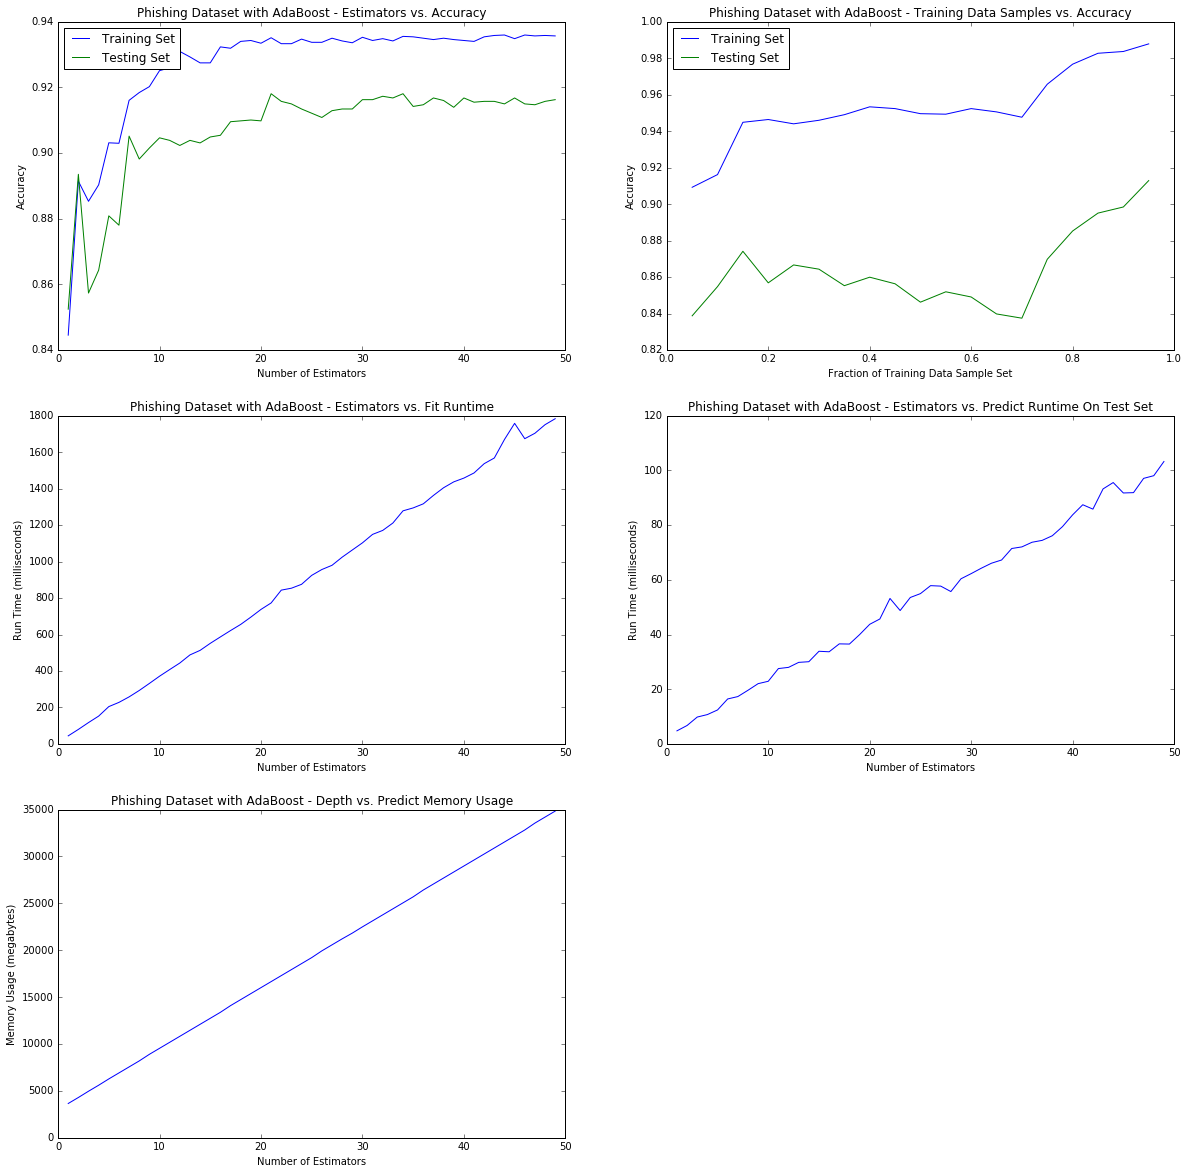

In [9]:
training_accuracy = []
testing_accuracy = []
fit_run_time = []
predict_run_time= []
memory_usage = []

depth_range = range(1,50)

for depth in depth_range:
    clf = ensemble.AdaBoostClassifier(n_estimators=depth)
    fit_run_time.append(timeit.timeit("clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])", 
                    "from __main__ import clf, df_training",
                     number = 10))
    
    clf = ensemble.AdaBoostClassifier(n_estimators=depth)
    clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])
    memory_usage.append(getsize(clf))
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
    
fig = plt.figure(figsize=(20,20))    
    
plt.subplot(321)
plt.plot(depth_range, training_accuracy)
plt.plot(depth_range, testing_accuracy)
plt.title("Phishing Dataset with AdaBoost - Estimators vs. Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

plt.subplot(323)
plt.title("Phishing Dataset with AdaBoost - Estimators vs. Fit Runtime")
plt.plot(depth_range, np.array(fit_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Number of Estimators")

plt.subplot(324)
plt.title("Phishing Dataset with AdaBoost - Estimators vs. Predict Runtime On Test Set")
plt.plot(depth_range, np.array(predict_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Number of Estimators")

plt.subplot(325)
plt.title("Phishing Dataset with AdaBoost - Depth vs. Predict Memory Usage")
plt.plot(depth_range, memory_usage)
plt.ylabel("Memory Usage (megabytes)")
plt.xlabel("Number of Estimators")

training_accuracy = []
testing_accuracy = []

percent_of_training_data = np.arange(.05,1.0,.05)

for percent in percent_of_training_data:
    clf = tree.DecisionTreeClassifier(criterion="entropy")
#    clf = ensemble.AdaBoostClassifier()
#    clf = svm.SVC()
#    clf = neighbors.NearestNeighbors()
    clf.fit(df_training.values[0:int(percent * len(df_training)),0:-2], \
            df_training.values[0:int(percent * len(df_training)),-1])
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))

plt.subplot(322)
plt.plot(percent_of_training_data, training_accuracy)
plt.plot(percent_of_training_data, testing_accuracy)
plt.title("Phishing Dataset with AdaBoost - Training Data Samples vs. Accuracy")
plt.xlabel("Fraction of Training Data Sample Set")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

